# Importing libraries, APIS & Tensorflow

In [1]:
# import future

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

# import tensorflow & tensorflow modules

import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    Conv2D,
    MaxPool2D)

from tensorflow.keras.preprocessing import image

# import libraries for data processing

import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# import keras libraries that will be used for the transfer learning

from keras.applications import xception
from keras import models
from keras import layers

# import libraries for diagrams and plots

import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sn

# import image related libraries

import PIL
from PIL import Image
from contextlib import redirect_stdout
import sys

# import glob for directories

import glob

Using TensorFlow backend.


In [2]:
# print file name

file_name =  os.path.basename(sys.argv[0])
file_name = str(file_name)

# Trim the ".py" extensiojn from the file 

file_name = file_name[:-3]

print("Name of the File:", file_name)

Name of the File: ipykernel_launcher


In [3]:
# set another (very high) limit for image processing as some pictures may create bottleneck

PIL.Image.MAX_IMAGE_PIXELS = 9933120000

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [4]:
# setting the paths, pathfiles

parent_dir = glob.glob(r'C:\**\SeAC Dataset/', recursive=True)
parent_dir = str(parent_dir[0])

# as the glob library provides the path in "\\" format we need to change it to "/"

parent_dir = parent_dir.replace('\\', '/')

path_train_images = parent_dir

saved_model_path = glob.glob(r'C:\**\Saved_Models/', recursive=True)
saved_model_path = str(saved_model_path[0])
saved_model_path = saved_model_path.replace('\\', '/')

path_scripts = glob.glob(r'C:\**\Scripts/', recursive=True)
path_scripts = str(path_scripts[0])
path_scripts = path_scripts.replace('\\', '/')

In [5]:
### Setting up all the parameters for the training, processing of data and produced files management ###

# import the labels of the dataset

train_labels_path = parent_dir + "Labels/" + "Classification_labels.xlsx"

data = pd.read_excel(train_labels_path, engine="openpyxl")

# check the 3 first lines of the dataframe to get  an idea of it

print(data.head(3))

           Artist_Name                      Painting_Name    Art_Genre  \
0  Wilhelm Kotarbinski  wilhelm-kotarbinski_roman-holiday  Art Nouveau   
1  Wilhelm Kotarbinski         wilhelm-kotarbinski_sappho  Art Nouveau   
2  Wilhelm Kotarbinski       wilhelm-kotarbinski_seraphim  Art Nouveau   

   Art Nouveau  Baroque  Impressionism  Italian Renaissance  \
0            1        0              0                    0   
1            1        0              0                    0   
2            1        0              0                    0   

   Post-Impressionism  Realism  Rococo  Romanticism  Street Art  Surrealism  
0                   0        0       0            0           0           0  
1                   0        0       0            0           0           0  
2                   0        0       0            0           0           0  


In [6]:
# check the number of rows and columns of the dataframe

print(data.shape)

(42964, 13)


In [14]:
### setting parameters for the training and also store them in a spreadsheet afterwards ###

# set batch size (in this code-example there is no use of it)

#num_batch = 10

# adjusting the size of images into the same dimensions

# Batch Normalization application or not

batch_norm = "Yes"

img_width = 250
img_height = 250

# adjsusting training parameters

lrn_rate = 0.0003  # learning rate
num_epochs = 30  # number of training epochs
act_func = "sigmoid"  # activation fuction

# 1st hidden layer

num_neurons_1st_hidden = 16
drop_perc_1st_hidden = 0.2

# 2nd hidden layer

num_neurons_2nd_hidden = 32
drop_perc_2nd_hidden = 0.3

# 3d hidden layer

num_neurons_3d_hidden = 64
drop_perc_3d_hidden = 0.4

# 4th hidden layer

num_neurons_4th_hidden = 128
drop_perc_4th_hidden = 0.5

# adjsusting training parameters in dense layers

num_neurons_1st_dense = 500 # number of neurons in first dense layer
drop_perc_1st_dense = 0 # percentage of dropout rate in first dense layer

num_neurons_2nd_dense = 250 # number of neurons in second dense layer
drop_perc_2nd_dense = 0 # percentage of dropout rate in second dense layer

num_neurons_3d_dense = 0 # number of neurons in third dense layer
drop_perc_3d_dense = 0 # percentage of dropout rate in third dense layer


In [8]:
# create an empty list to take in the images

X = []

# attach the images with the labels, in order to have supervised learning and convert them to have values between 0 - 1 by multiplying with 255 (RGB values: 0 - 255)

for i in tqdm(range(data.shape[0])):
    path = (
        path_train_images
        + data["Art_Genre"][i]
        + "/"
        + data["Artist_Name"][i]
        + "/"
        + data["Painting_Name"][i]
        + ".jpg"
    )
    img = image.load_img(path, target_size=(img_width, img_height, 3))
    img = image.img_to_array(img)
    img = img / 255.0
    X.append(img)

# convert images into np array

X = np.array(X)

100%|██████████| 42964/42964 [20:40<00:00, 34.63it/s] 


In [9]:
# get the size of dataframe X

print("The shape of X dataframe is: ", X.shape)

The shape of X dataframe is:  (42964, 250, 250, 3)


In [10]:
# removing "unnecessary" columns, in order to have only the one-hot encoded columns for the training

y = data.drop(["Artist_Name", "Painting_Name", "Art_Genre"], axis=1)
y = np.array(y)

# inspect the size of new labels dataframe and make sure that columns match the number of classes

print("The shape of y list is: ", y.shape)

The shape of y list is:  (42964, 10)


In [11]:
# set that the evaluation to 10% of the total dataset
# the testing dataset will be 20% of the total dataset
# the final percentage of training set will be 70% of the total dataset

# create the train/test sets, set the size of test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# create the test/validation sets, set the size of validation set

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=1)

# get the shapes of train, test and validation splits

print("The shape of X_train is: ", X_train.shape)
print("The shape of y_train is: ", y_train.shape)

print("The shape of X_test is: ", X_test.shape)
print("The shape of y_test is: ", y_test.shape)

print("The shape of X_val is: ", X_val.shape)
print("The shape of y_val is: ", y_val.shape)

The shape of X_train is:  (30074, 250, 250, 3)
The shape of y_train is:  (30074, 10)
The shape of X_test is:  (8593, 250, 250, 3)
The shape of y_test is:  (8593, 10)
The shape of X_val is:  (4297, 250, 250, 3)
The shape of y_val is:  (4297, 10)


In [12]:
# create the convolutional network

# set the model as sequential
# imply batchnormalization in every layer to make training faster
# imply dropout in each hidden layer to avoid overfitting

model = Sequential()

# 1st hidden layer

model.add(Conv2D(num_neurons_1st_hidden, (3, 3), activation="relu", input_shape=X_train[0].shape, padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2, 2))
model.add(Dropout(drop_perc_1st_hidden))

# 2nd hidden layer

model.add(Conv2D(num_neurons_2nd_hidden, (3, 3), activation="relu", padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2, 2))
model.add(Dropout(drop_perc_2nd_hidden))

# 3d hidden layer

model.add(Conv2D(num_neurons_3d_hidden, (3, 3), activation="relu", padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2, 2))
model.add(Dropout(drop_perc_3d_hidden))

# 4th hidden layer

model.add(Conv2D(num_neurons_4th_hidden, (3, 3), activation="relu", padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2, 2))
model.add(Dropout(drop_perc_4th_hidden))

# flatten all the layers

model.add(Flatten())

# add the dense layer to obtain all the information from the hidden layers

model.add(Dense(num_neurons_1st_dense, activation="relu"))
model.add(Dropout(drop_perc_1st_dense))

# add a 2nd dense layer to get better results

model.add(Dense(num_neurons_2nd_dense, activation="relu"))
model.add(Dropout(drop_perc_2nd_dense))


# add the final, output layer to get the information regarding multi-class classification

model.add(Dense(10, activation=act_func))

# Show a summary of the model. Check the number of trainable parameters

model.summary()    

Model: 'Sequential'                                                
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 250, 250, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 250, 250, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 125, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 125, 125, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 125, 125, 32)      128       
_________________________________________________________________
batch_no

In [15]:
# set the optimizer and loss functions to measure and adjust the weighs of parameters in layer for every iteration

Adam = tf.keras.optimizers.Adam(
    learning_rate=lrn_rate, beta_1=0.9, beta_2=0.999, amsgrad=False
)
model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=["accuracy"])

# train the model

history = model.fit(
    X_train, y_train, epochs=num_epochs, validation_data=(X_test, y_test)
)

Epoch 1/30
940/940 [==============================] - 196s 149ms/step - loss: 0.5233 - accuracy: 0.2748 - val_loss: 0.2863 - val_accuracy: 0.3288
Epoch 2/30
940/940 [==============================] - 59s 63ms/step - loss: 0.2464 - accuracy: 0.4302 - val_loss: 0.2578 - val_accuracy: 0.4072
Epoch 3/30
940/940 [==============================] - 61s 65ms/step - loss: 0.2235 - accuracy: 0.4936 - val_loss: 0.2661 - val_accuracy: 0.4260
Epoch 4/30
940/940 [==============================] - 59s 63ms/step - loss: 0.2100 - accuracy: 0.5322 - val_loss: 0.2318 - val_accuracy: 0.4793
Epoch 5/30
940/940 [==============================] - 60s 63ms/step - loss: 0.1963 - accuracy: 0.5676 - val_loss: 0.2787 - val_accuracy: 0.4013
Epoch 6/30
940/940 [==============================] - 61s 65ms/step - loss: 0.1821 - accuracy: 0.6045 - val_loss: 0.2380 - val_accuracy: 0.4717
Epoch 7/30
940/940 [==============================] - 61s 65ms/step - loss: 0.1658 - accuracy: 0.6480 - val_loss: 0.2436 - val_accurac

In [16]:
# summarize history for accuracy

scores = model.evaluate(
    X_test,
    y_test,
    verbose=1,
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
)

print(scores)

print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


In [17]:
# Create lists with accuracy and loss metrics that will be stored later in a .txt file for possible future use

epoch_list = []

acc_list = history.history["acc"]
print('accuracy list:', acc_list)

val_acc_list = history.history["val_acc"]
print('validation accuracy list:', val_acc_list)

loss_list = history.history["loss"]
print('loss list:', loss_list)

val_loss_list = history.history["val_loss"]
print('validation loss list:', val_loss_list)

accuracy list: [0.7401962, 0.85686284, 0.8867647, 0.9259805, 0.9514705, 0.9671568, 0.9828432, 0.9882352, 0.992647, 0.99362737]
validation accuracy list: [0.8661017417907715, 0.8728813529014587, 0.8881354928016663, 0.9152542352676392, 0.9101694226264954, 0.9118644595146179, 0.9305084347724915, 0.9389830827713013, 0.9355932474136353, 0.9372880458831787]
loss list: [0.5322616781089821, 0.3586186406513055, 0.2564006428069928, 0.1975214942267128, 0.14892803883070455, 0.10035280648655459, 0.06074147110841438, 0.04248180533257112, 0.03320482416265626, 0.024953396653062572]
validation loss list: [0.40771958181413553, 0.3280265098911221, 0.2826197761095176, 0.23933216525336443, 0.23545103583295465, 0.2590985502732002, 0.22513787991414635, 0.211532658123869, 0.20161563265374152, 0.25578001842407855]


In [18]:
# Create smoother lines in the graphs
# If this step is not taken, the same diagrams will be plotted, but with "sharper" edges

epoch_lim = num_epochs + 1

for i in range(1, epoch_lim):
    epoch_list.append(i)
    
x_plot = np.array(epoch_list)

y_plot_acc = np.array(history.history["acc"])
y_plot_val_acc = np.array(history.history["val_acc"])

X_Y_Spline_acc = make_interp_spline(x_plot, y_plot_acc)
X_Y_Spline_val_acc = make_interp_spline(x_plot, y_plot_val_acc)

# Returns evenly spaced numbers
# over a specified interval.

X_plot = np.linspace(x_plot.min(), x_plot.max())
y_plot_acc = X_Y_Spline_acc(X_plot)
y_plot_val_acc = X_Y_Spline_val_acc(X_plot)

In [ ]:
# plot the accuracy for train/test sets to check for overfitting or underfitting (less possible)
# Plotting the Graph

plt.plot(X_plot, y_plot_acc)
plt.plot(X_plot, y_plot_val_acc)
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="lower right")
plt.savefig(
    saved_model_path
    + file_name + "_model_accuracy.png"
)

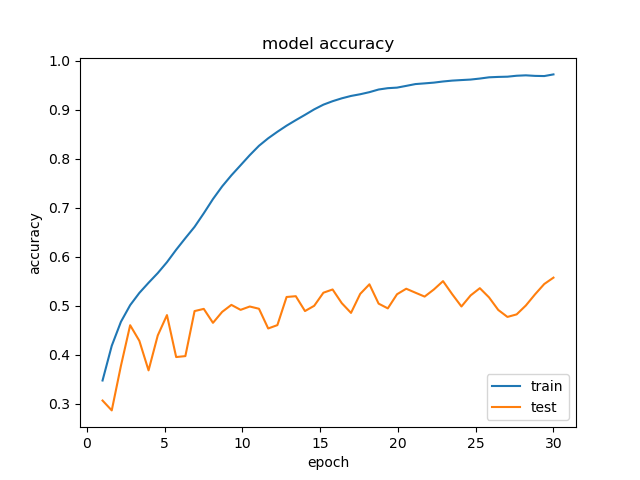

In [ ]:
# clear the plot area

plt.figure().clear()
plt.close()
plt.cla()
plt.clf()

In [ ]:
# plot the loss for train/test sets to check again for overfitting or underfitting

# create "smoother" lines

y_plot_loss = np.array(history.history["loss"])
y_plot_val_loss = np.array(history.history["val_loss"])

X_Y_Spline_loss = make_interp_spline(x_plot, y_plot_loss)
X_Y_Spline_val_loss = make_interp_spline(x_plot, y_plot_val_loss)

# Returns evenly spaced numbers
# over a specified interval.

y_plot_loss = X_Y_Spline_loss(X_plot)
y_plot_val_loss = X_Y_Spline_val_loss(X_plot)

# Plotting the Graph

plt.plot(X_plot, y_plot_loss)
plt.plot(X_plot, y_plot_val_loss)
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper right")
plt.savefig(
    saved_model_path
    + file_name + "_model_loss.png"
)

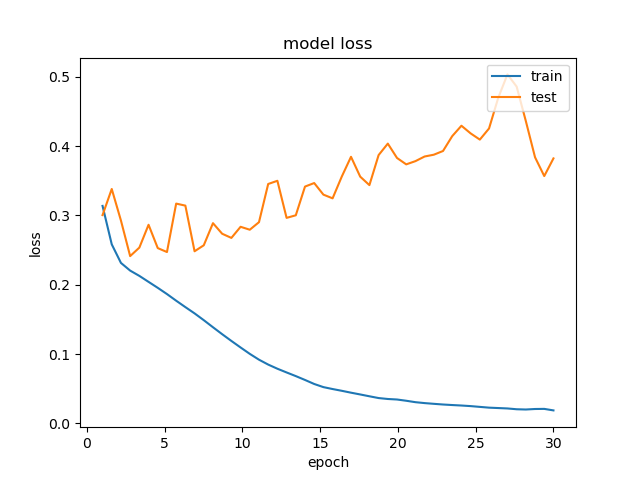

In [ ]:
# make predictions

predictions = model.predict(X_val)

# get the max values of the predictions and true values to get the metric values

predictions = np.argmax(predictions, axis=1)
y_val = np.argmax(y_val, axis=1)

accuracy_rate = accuracy_score(y_val, predictions)

accuracy_rate = accuracy_rate * 100
accuracy_rate = round(accuracy_rate, 2)

In [21]:
print("Success rate: {} %".format(accuracy_rate))

Success rate: 78.47 %


In [ ]:
# create a txt file to save the training parameters of the created model

with open(
    (
        saved_model_path
        + file_name + "_configuration.txt"
    ),
    "w",
) as f:
    f.write(
        "Successful identification rate: {} % \nNumber of epochs: {} \nLearning rate: {} \nImage height and width: {} \nActivation function: {} \naccuracy list: {} \nvalidation accuracy list: {} \nloss list: {} \nvalidation loss list: {} \n\n\n\n\n\n\n\n{}".format(
            accuracy_rate,
            num_epochs,
            lrn_rate,
            img_width,
            act_func,
            acc_list,
            val_acc_list,
            loss_list,
            val_loss_list,
            model.summary(),
        )
    )
    
# add the model summary to the created txt file

with open(
    (
        saved_model_path
        + file_name + "_configuration.txt"
    ),
    "a",
) as f:
    with redirect_stdout(f):
        model.summary()

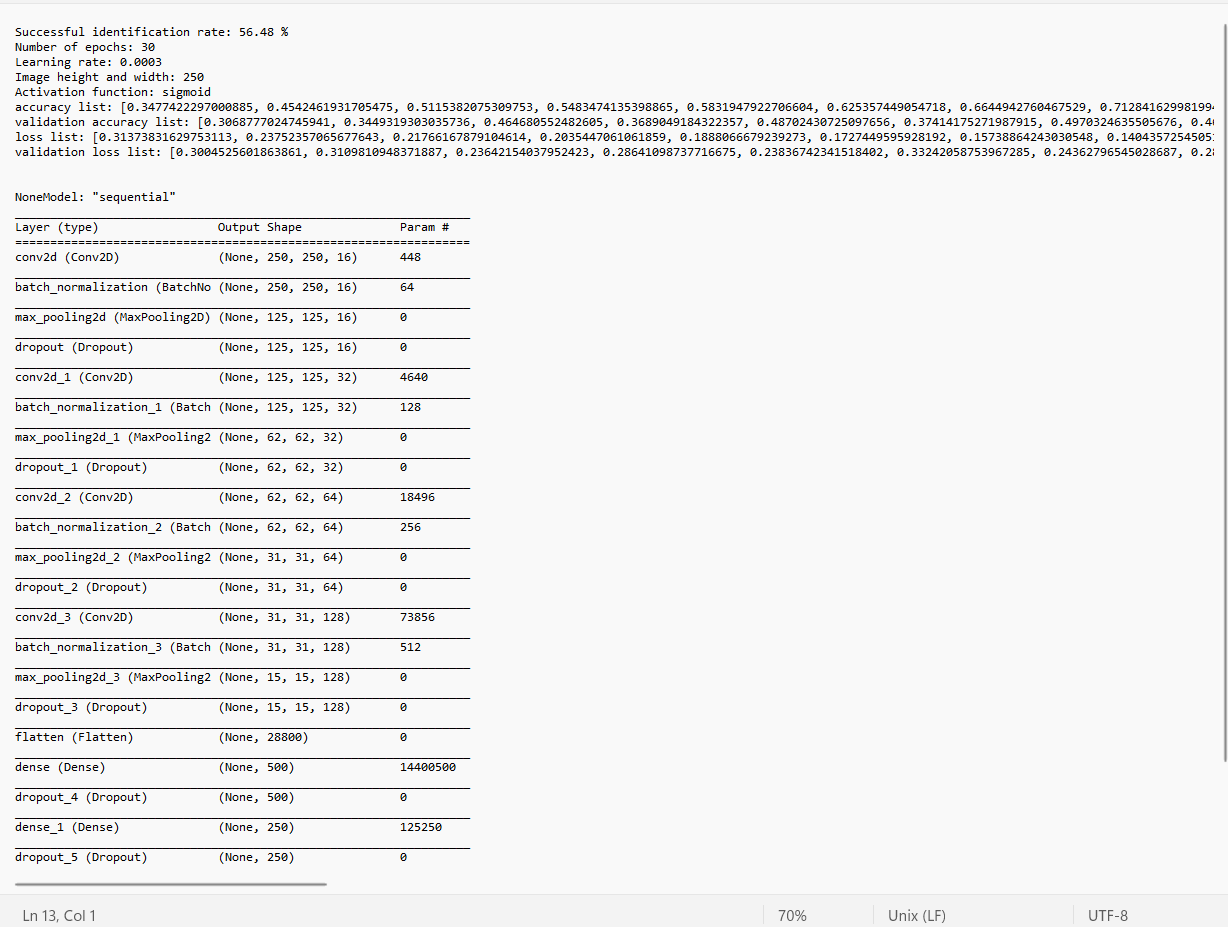

In [ ]:
# construct a confussion matrix to examine in which style the code performed better

conf_mat = confusion_matrix(y_val, predictions)

# get the names of the classes that correspond to the binary data-predictions/true values

cols_list = data['Art_Genre'].unique()
class_names = cols_list

# make a dataframe of the confusion matrix

conf_mat_dataframe = pd.DataFrame(
    conf_mat, index=[i for i in class_names], columns=[i for i in class_names]
)

# plot and save the confusion matrix
# format the confusion matrix in order to have a "nicer" output

plt.figure(figsize=(20, 16))
plt.rcParams.update({"font.size": 18})
plt.rcParams.update({"font.family": "georgia"})
plt.locator_params(axis="both", integer=True, tight=True)
plt.title("Confusion Matrix")
sn.heatmap(
    conf_mat_dataframe,
    annot=True,
    linewidths=0.1,
    linecolor="g",
    cbar=True,
    cmap="cividis",
)

plt.savefig(
    saved_model_path
    + file_name + "_confusion_matrix.png"
)

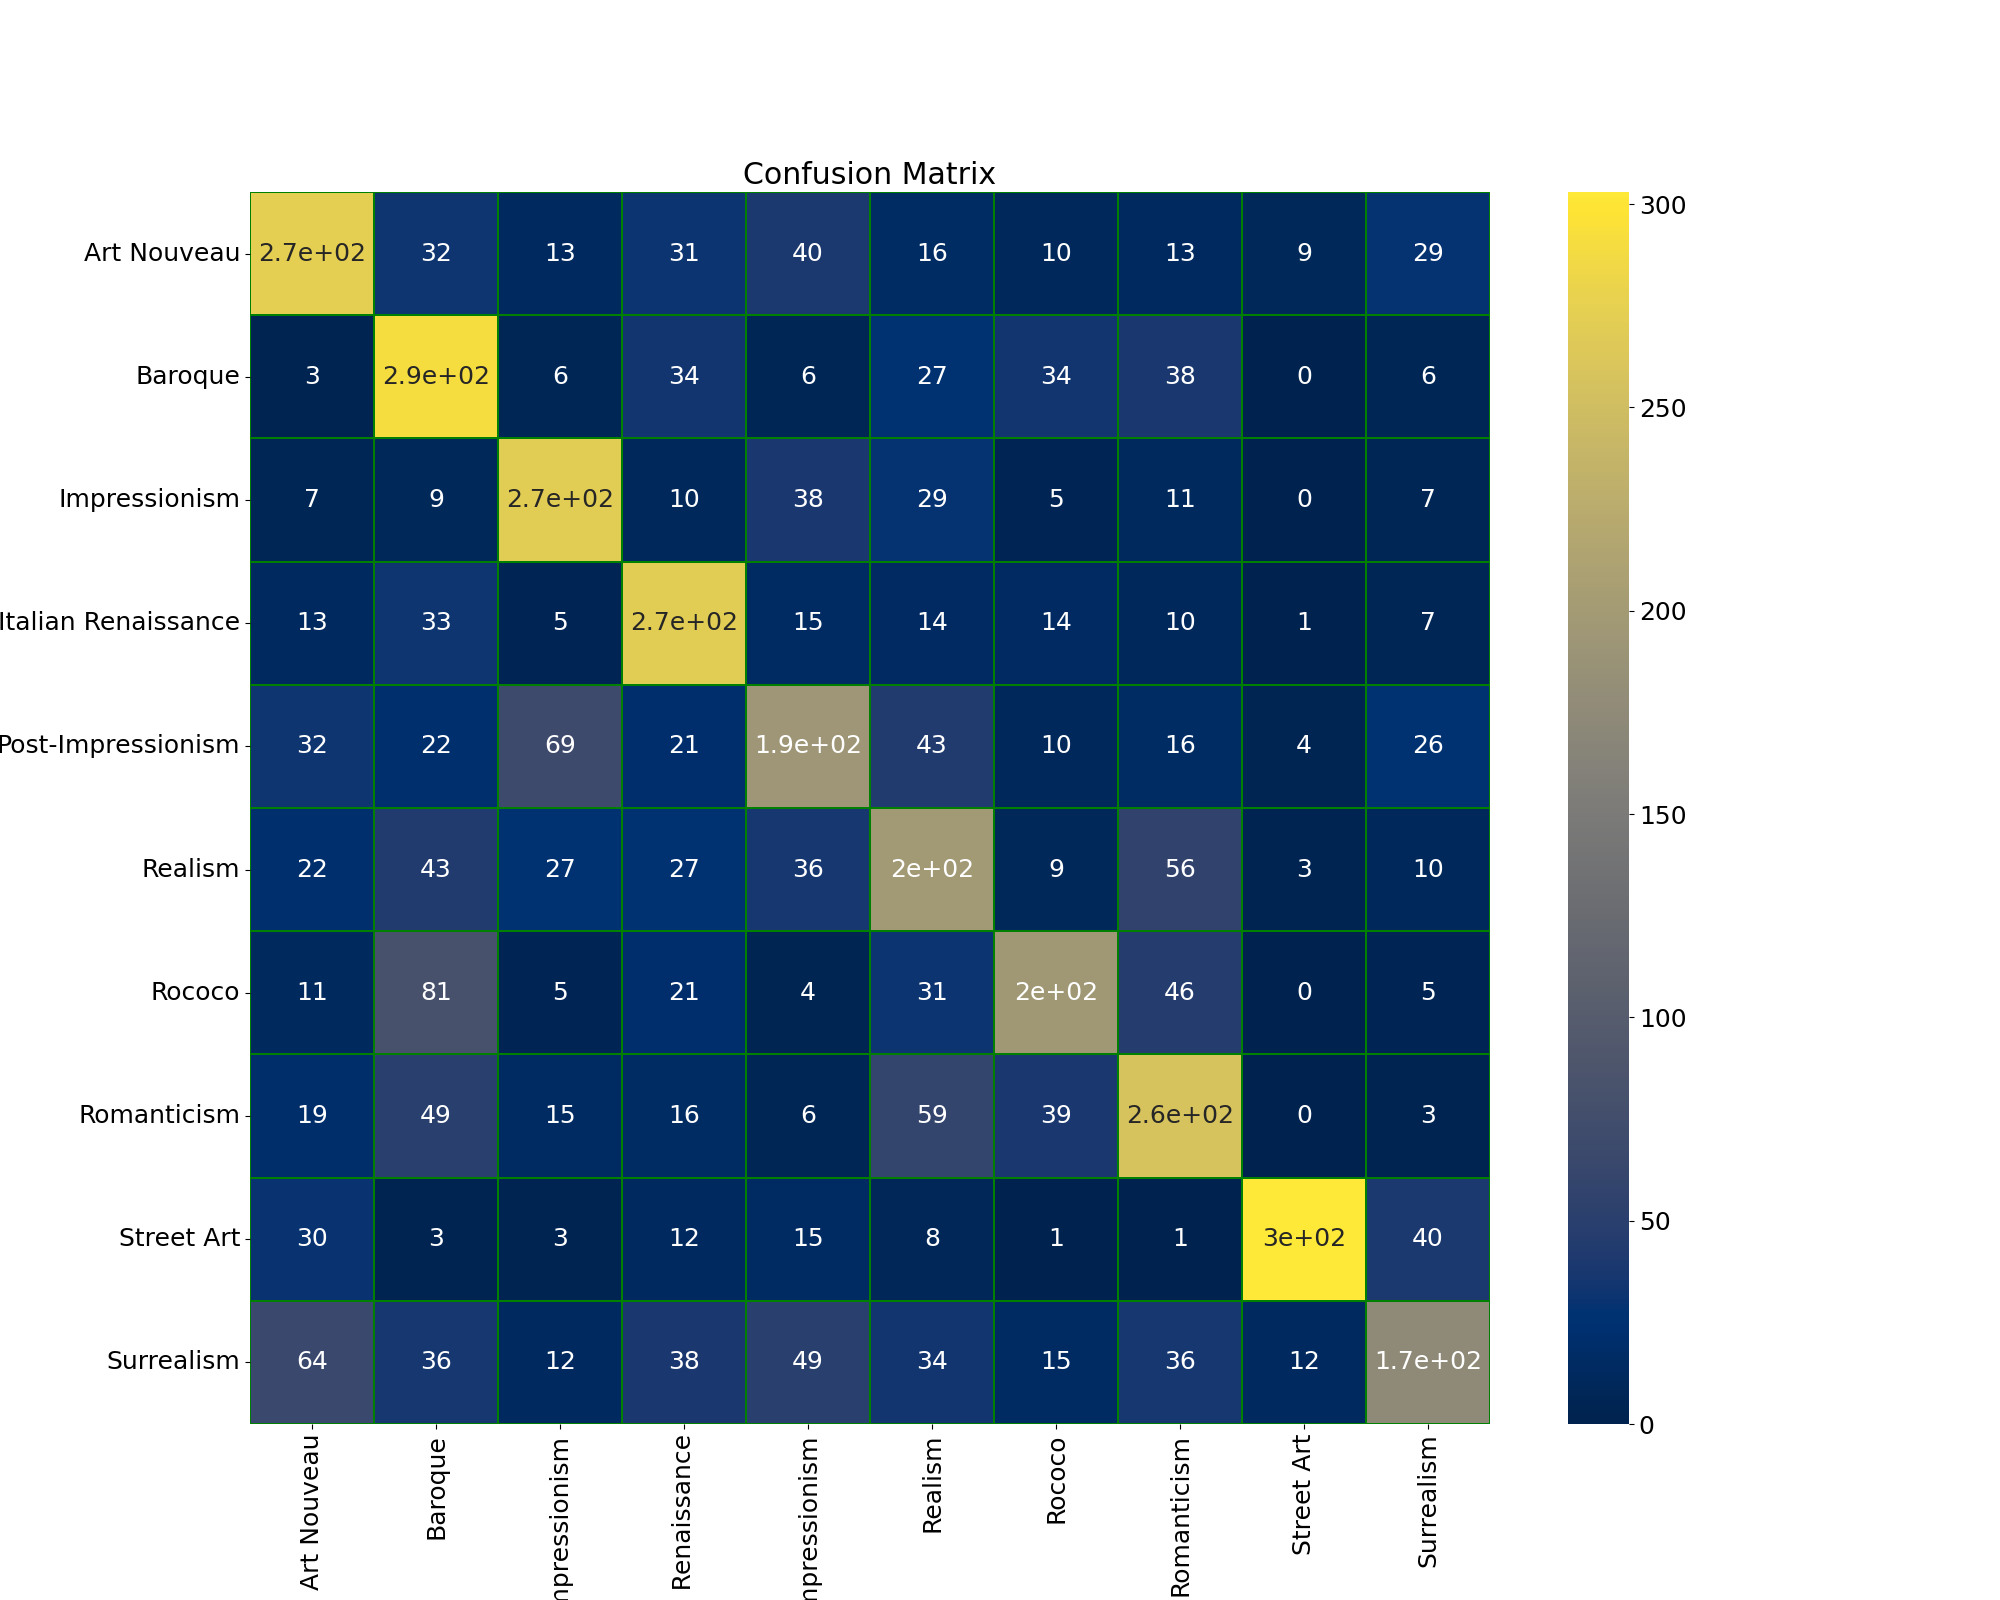

In [ ]:
# open and set the config file to enter all the training parameters
# and performance results

df_config = pd.read_excel(saved_model_path + "Config_customs.xlsx",
                          engine = "openpyxl")

# set the number of row to enter the inputs from this script

input_placeholder = len(df_config)
input_placeholder = input_placeholder + 1

# enter the name of file in config dataset

df_config.at[input_placeholder, 'File'] = file_name

# enter the accuracy percentage in config dataset

df_config.at[input_placeholder, 'Rate (%)'] = accuracy_rate

# enter the dimensions of the input images in config dataset

df_config.at[input_placeholder, 'Hight/Width'] = img_width

# enter the epochs number in config dataset

df_config.at[input_placeholder, 'Epochs'] = num_epochs

# enter the learning rate value in config dataset

df_config.at[input_placeholder, 'Learning_Rate'] = lrn_rate

# enter the activation function in config dataset

df_config.at[input_placeholder, 'Act_Func.'] = act_func

# enter if batch normalization is applied 

df_config.at[input_placeholder, 'Batch_Norm.'] = batch_norm

# enter the number of neurons of first hidden layer in config dataset

df_config.at[input_placeholder, 'Neuron_1st_Hidden'] = num_neurons_1st_hidden

# enter the dropout rate of first hidden layer in config dataset

df_config.at[input_placeholder, 'Dropout_1st_Hidden'] = drop_perc_1st_hidden

# enter the number of neurons of second hidden layer in config dataset

df_config.at[input_placeholder, 'Neuron_2nd_Hidden'] = num_neurons_2nd_hidden

# enter the dropout rate of second hidden layer in config dataset

df_config.at[input_placeholder, 'Dropout_2nd_Hidden'] = drop_perc_2nd_hidden

# enter the number of neurons of third hidden layer in config dataset

df_config.at[input_placeholder, 'Neuron_3d_Hidden'] = num_neurons_3d_hidden

# enter the dropout rate of third hidden layer in config dataset

df_config.at[input_placeholder, 'Dropout_3d_Hidden'] = drop_perc_3d_hidden

# enter the number of neurons of fourth hidden layer in config dataset

df_config.at[input_placeholder, 'Neuron_4th_Hidden'] = num_neurons_4th_hidden

# enter the dropout rate of third hidden layer in config dataset

df_config.at[input_placeholder, 'Dropout_4th_Hidden'] = drop_perc_4th_hidden

# enter the number of neurons of first dense layer in config dataset

df_config.at[input_placeholder, 'Neuron_1st_Dense'] = num_neurons_1st_dense

# enter the dropout rate of first dense layer in config dataset

df_config.at[input_placeholder, 'Dropout_1st_Dense'] = drop_perc_1st_dense

# enter the number of neurons of second dense layer in config dataset

df_config.at[input_placeholder, 'Neuron_2nd_Dense'] = num_neurons_2nd_dense

# enter the dropout rate of second dense layer in config dataset

df_config.at[input_placeholder, 'Dropout_2nd_Dense'] = drop_perc_2nd_dense

# enter the number of neurons of third dense layer in config dataset

df_config.at[input_placeholder, 'Neuron_3d_Dense'] = num_neurons_3d_dense

# enter the dropout rate of third dense layer in config dataset

df_config.at[input_placeholder, 'Dropout_3d_Dense'] = drop_perc_3d_dense

# save the config dataset

df_config.to_excel(saved_model_path + "Config_customs.xlsx",
                   engine='openpyxl',
                   index = False)

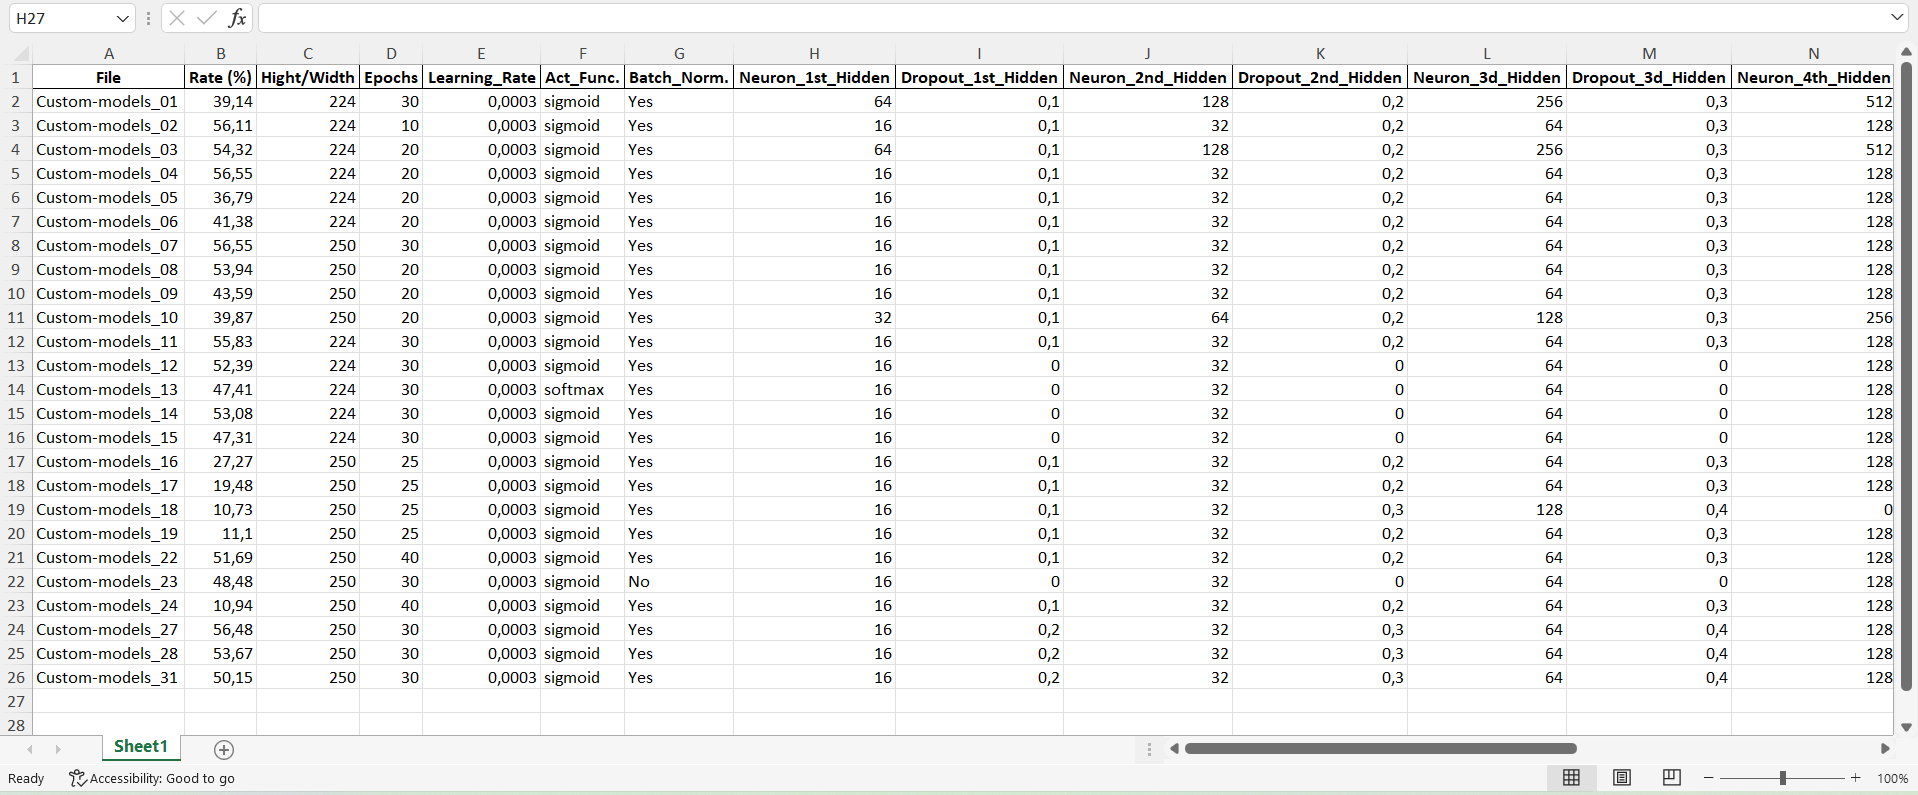

In [ ]:
### Rename the script file to add the accuracy percentage in the file name

file_before = path_scripts + file_name + ".py" 
file_after = path_scripts + file_name + "_(" + str(accuracy_rate) + ")"  + ".py"

os.rename(file_before, file_after)

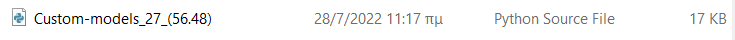